In [1]:
import pandas as pd
import numpy as np
from umap import UMAP
from umap import plot as umap_plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import bokeh
from bokeh.io import output_notebook
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

c:\Users\Paulo\anaconda3\envs\COMMONLIT\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\Paulo\anaconda3\envs\COMMONLIT\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning,)

In [4]:
text_ref = pd.read_parquet('../input/text_emb.parquet')
summaries = pd.read_parquet('../input/sum_emb.parquet')

train_prompt = pd.read_csv('../../../prompts_train.csv')
train_summaries = pd.read_csv('../../../summaries_train.csv')

In [5]:
text_ref = text_ref.T
text_ref.index.name = 'prompt_id'

summaries = summaries.T
summaries.index.name = 'student_id'

In [6]:
display(text_ref.head(1), summaries.head(1), train_prompt.head(1), train_summaries.head(1))

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
prompt_id,,,,,,,,,,,,,,,,,,,,,
39c16e,-0.044322,0.080737,0.031065,-0.011584,-0.009389,0.052562,0.034647,0.024612,0.009266,-0.023828,...,0.066465,-0.074595,-0.01164,0.113665,-0.070106,0.037373,0.124775,0.00318,0.01088,-0.092459


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
student_id,,,,,,,,,,,,,,,,,,,,,
000e8c3c7ddb,-0.032302,-0.061624,-0.039432,-0.024158,0.010305,-0.018682,-0.032586,-0.018416,-0.035339,0.065142,...,0.038178,0.051087,-0.078121,-0.000082,-0.135634,0.000321,0.088186,0.019669,-0.067355,0.07477


,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538


In [7]:
text_ref = (
    train_prompt.drop(['prompt_question','prompt_text'], axis=1)
    .merge(text_ref, how='left',on='prompt_id')
)
text_ref.head(2)

,prompt_id,prompt_title,0,1,2,3,4,5,6,7,...,374,375,376,377,378,379,380,381,382,383
0,39c16e,On Tragedy,-0.044322,0.080737,0.031065,-0.011584,-0.009389,0.052562,0.034647,0.024612,...,0.066465,-0.074595,-0.011640,0.113665,-0.070106,0.037373,0.124775,0.003180,0.010880,-0.092459
1,3b9047,Egyptian Social Structure,-0.083477,0.105279,0.030022,0.022780,-0.049433,-0.031991,0.033304,-0.007340,...,-0.028389,-0.129694,-0.083241,0.066339,0.051831,-0.064965,0.088054,0.030493,-0.020967,-0.048807


In [8]:
summaries = (
    train_prompt.drop(['prompt_question','prompt_text'],axis=1)
    .merge(train_summaries, how='right', on='prompt_id')
    .merge(summaries, how='left', on='student_id')
)

summaries.head(2)

,prompt_id,prompt_title,student_id,text,content,wording,0,1,2,3,...,374,375,376,377,378,379,380,381,382,383
0,814d6b,The Third Wave,000e8c3c7ddb,The third wave was an experimentto see how peo...,0.205683,0.380538,-0.032302,-0.061624,-0.039432,-0.024158,...,0.038178,0.051087,-0.078121,-0.000082,-0.135634,0.000321,0.088186,0.019669,-0.067355,0.074770
1,ebad26,Excerpt from The Jungle,0020ae56ffbf,They would rub it up with soda to make the sme...,-0.548304,0.506755,-0.021375,0.085844,0.033094,0.071630,...,0.017595,0.003423,0.043537,0.006860,0.093196,-0.034472,0.054477,-0.008644,-0.058420,0.015333


In [9]:
umap_model = UMAP()

In [10]:
summaries_embeddings = umap_model.fit(summaries.loc[:, 0:])

In [11]:
# umap_plot.points(temp_umap, labels=summaries.prompt_title)
df_summaries = pd.concat([
    summaries,
    pd.DataFrame(summaries_embeddings.embedding_, columns=['x','y'])
], axis=1)

In [12]:
# summaries_embeddings.embedding_

text_embeddings = summaries_embeddings.transform(text_ref.loc[:, 0:])

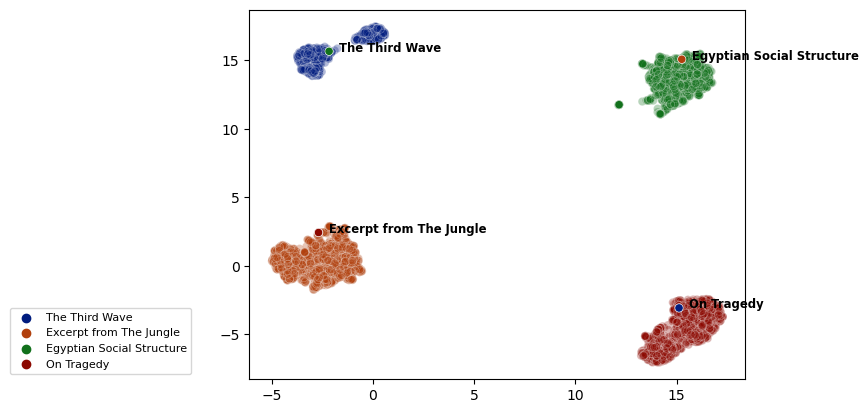

In [13]:
g = sns.scatterplot(df_summaries, x='x', y='y', hue='prompt_title',
                palette='dark', alpha=.3)
 
sns.scatterplot(x=text_embeddings[:, 0], y=text_embeddings[:, 1], 
                 palette='dark', markers='x', hue=train_prompt.prompt_title, legend=False, ax=g)

for i, annot in enumerate(text_embeddings):
    g.text(text_embeddings[i,0] + 0.5, text_embeddings[i,1],
           train_prompt.loc[i, 'prompt_title'], size='small', weight='semibold' )
g.set(xlabel=None, ylabel=None)
sns.move_legend(g, loc='lower center', title='', fontsize=8, bbox_to_anchor=(-0.3, 0))
# plt.axis('off')

In [14]:
for i, txt in enumerate(text_embeddings):
    print(text_embeddings[i,0], text_embeddings[i,1], train_prompt.loc[i, 'prompt_title'])

15.119727 -3.0644917 On Tragedy
15.254731 15.081882 Egyptian Social Structure
-2.1625702 15.664013 The Third Wave
-2.6835315 2.439473 Excerpt from The Jungle


In [16]:
wc = WordCloud(background_color='white',width=600, height=400).generate_from_text(''.join(summaries.text))

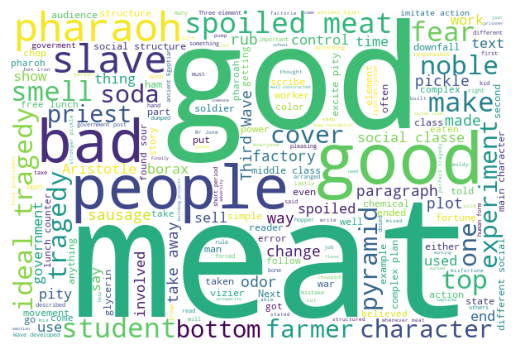

In [17]:
plt.imshow(wc)
plt.axis('off')
plt.show()

Egyptian Social Structure


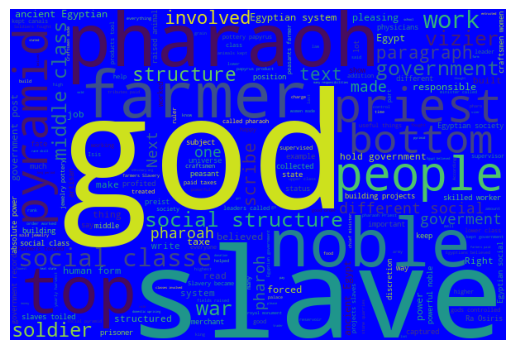

Excerpt from The Jungle


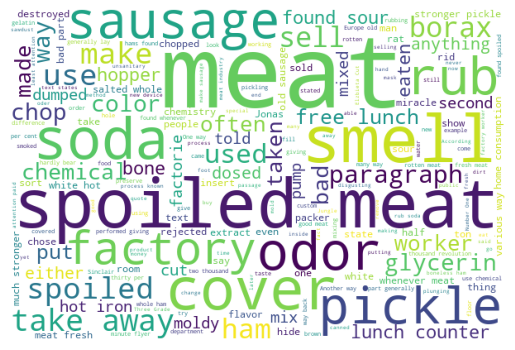

On Tragedy


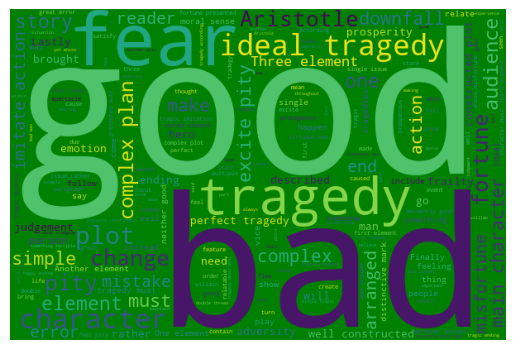

The Third Wave


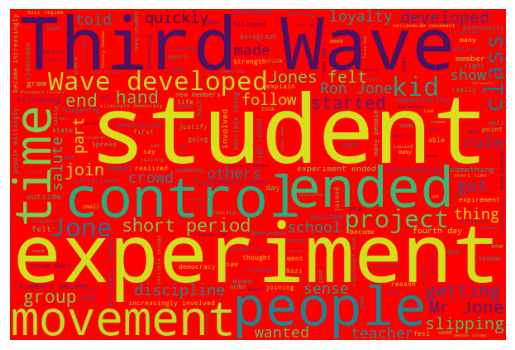

In [18]:
texts = summaries.groupby('prompt_title')['text']
bc_color = 'white'
width = 600
height = 400
colors = ['blue','white','green','red']


for c, (name, group) in enumerate(texts):
    print(name)
    wc = WordCloud(
        background_color=colors[c], 
        width=width, 
        height=height,
        ).generate(''.join(group))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

c:\Users\Paulo\anaconda3\envs\COMMONLIT\lib\site-packages\umap\plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<Axes: >

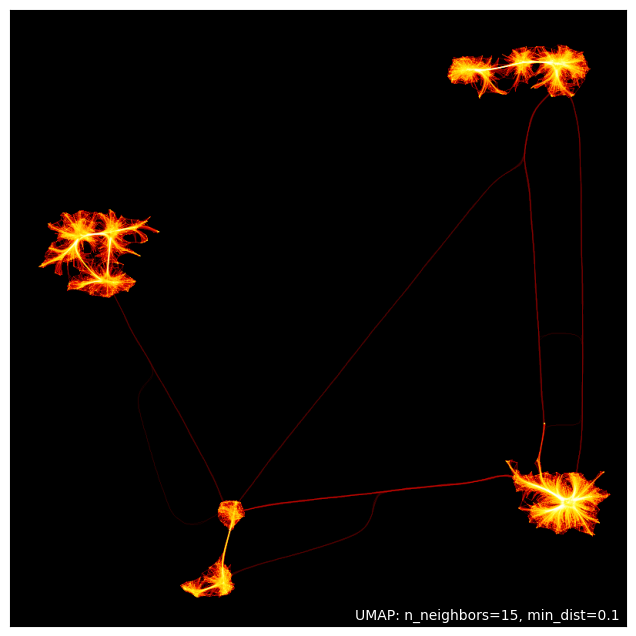

In [67]:
umap_plot.connectivity(summaries_embeddings, edge_bundling='hammer', theme='fire')
